In [7]:
import numpy as np
from numpy import pi, log, sqrt, exp, sin
import scipy
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import csv
import pandas as pd
from astropy.utils.data import get_pkg_data_filename
from astropy.io import ascii, fits
import brewer2mpl
from scipy.special import wofz

bmap = brewer2mpl.get_map('Set1', 'Qualitative', 3)
colors = bmap.mpl_colors

from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True
})

plt.rc('font', size=15)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,newtxmath}')

def smooth(x, window_len=11, window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1-dimensional arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if window not in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window must be one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len) if window == 'flat' else eval(f'np.{window}(window_len)')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y

def Voigt(a, u):
    I = integrate.quad(lambda y: np.exp(-y**2)/(a**2 + (u - y)**2), -np.inf, np.inf)[0]
    return (a/pi) * I

def G(x, alpha):
    return sqrt(log(2) / pi) / alpha * exp(-(x / alpha)**2 * log(2))

def L(x, gamma):
    return gamma / pi / (x**2 + gamma**2)

def V(x, alpha, gamma):
    sigma = alpha / sqrt(2 * log(2))
    return np.real(wofz((x + 1j*gamma)/sigma/sqrt(2))) / sigma / sqrt(2*pi)

def sigma_line(lambd, f, gamma, b_km, wave=[]):
    c = 2.997925e10 
    lam = lambd * 1.e-8
    nu = c / lam
    dnu = nu / c * b_km * 1.e5
    a = gamma / (4.*pi*dnu)
    if not wave:
        print('Computing wavelength grid...')
        lmin = lam - c/nu**2 * (sqrt(2.654e-2*f*gamma*nu/c)*5e-4 + 10.*dnu)
        lmax = lam + c/nu**2 * (sqrt(2.654e-2*f*gamma*nu/c)*5e-4 + 10.*dnu)
        wave = np.linspace(lmin, lmax, 1000)
    freq = c / wave
    u_range = (freq - nu) / dnu
    h = np.array([Voigt(a, round(u, 2)) / dnu / sqrt(pi) for u in u_range])
    sig = 2.654e-2 * f * h
    return np.column_stack((wave * 1.e8, sig))

def gconv(x, sigma):
    if sigma == 0:
        return x
    ksize = round(4.0 * sigma + 1.0) * 2
    xx = np.linspace(0.0, ksize, ksize, endpoint=False) - ksize / 2
    kernel = exp(-xx**2 / (2 * sigma**2))
    kernel /= sum(kernel)
    return np.convolve(x, kernel, mode='same')

def lyb_ab(x, vout, b, log_n, wave0, f, A, fcov, reddy, ebv, vdisp):
    cspeed = 299989.
    x0 = wave0 * (vout/cspeed + 1.)
    tau_line = sigma_line(x0, f, A, b, x)
    N_line = 10.**log_n
    tau = N_line * tau_line[:, 1]
    flux = exp(-tau)
    return flux

def H(a, x):
    P = x**2
    H0 = np.exp(-x**2)
    Q = 1.5 / x**2
    return H0 - a / sqrt(pi) / P * (H0**2 * (4.*P**2 + 7.*P + 4. + Q) - Q - 1)

def Voigt(wl, l0, f, N, b, gam, z=0):
    c = 2.99792e10
    m_e = 9.1094e-28
    e = 4.8032e-10
    C_a = sqrt(pi) * e**2 * f * l0 * 1.e-8 / m_e / c / b
    a = l0 * 1.e-8 * gam / (4. * pi * b)
    dl_D = b / c * l0
    wl = wl / (z + 1.)
    x = (wl - l0) / dl_D + 0.00001
    tau = np.float64(C_a) * N * H(a, x)
    return tau


# Reading spectra

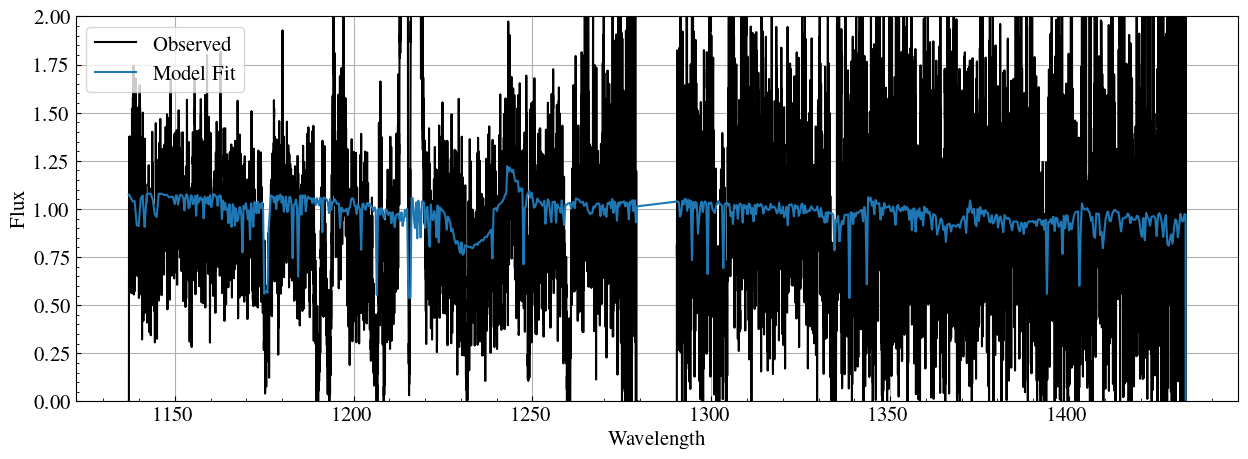

[1327.1942]


In [9]:
hduin = fits.open('Data/GP12440216/FitFiles/GP1244+0216_stellarfit_1200_1500.fits')
data_header = hduin[1].header
data_content = hduin[1].data

plt.figure(figsize=(15, 5))
plt.plot(data_content[0][1], data_content[0][2], 'k', label='Observed')
plt.plot(data_content[0][1], data_content[0][5], label='Model Fit')

plt.ylim(0, 2)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.grid(True)
plt.show()

selected_wavelengths = data_content[0][1][data_content[0][2] == 1]
print(selected_wavelengths)


# E(B-V) difference in fits

/tmp/ipykernel_446965/982142716.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(lines[:2], labels = ['Observed flux', 'Error'],fontsize=25, frameon=False, \
/tmp/ipykernel_446965/982142716.py:53: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(lines[:2], labels = ['Observed flux', 'Error'],fontsize=25, frameon=False, \


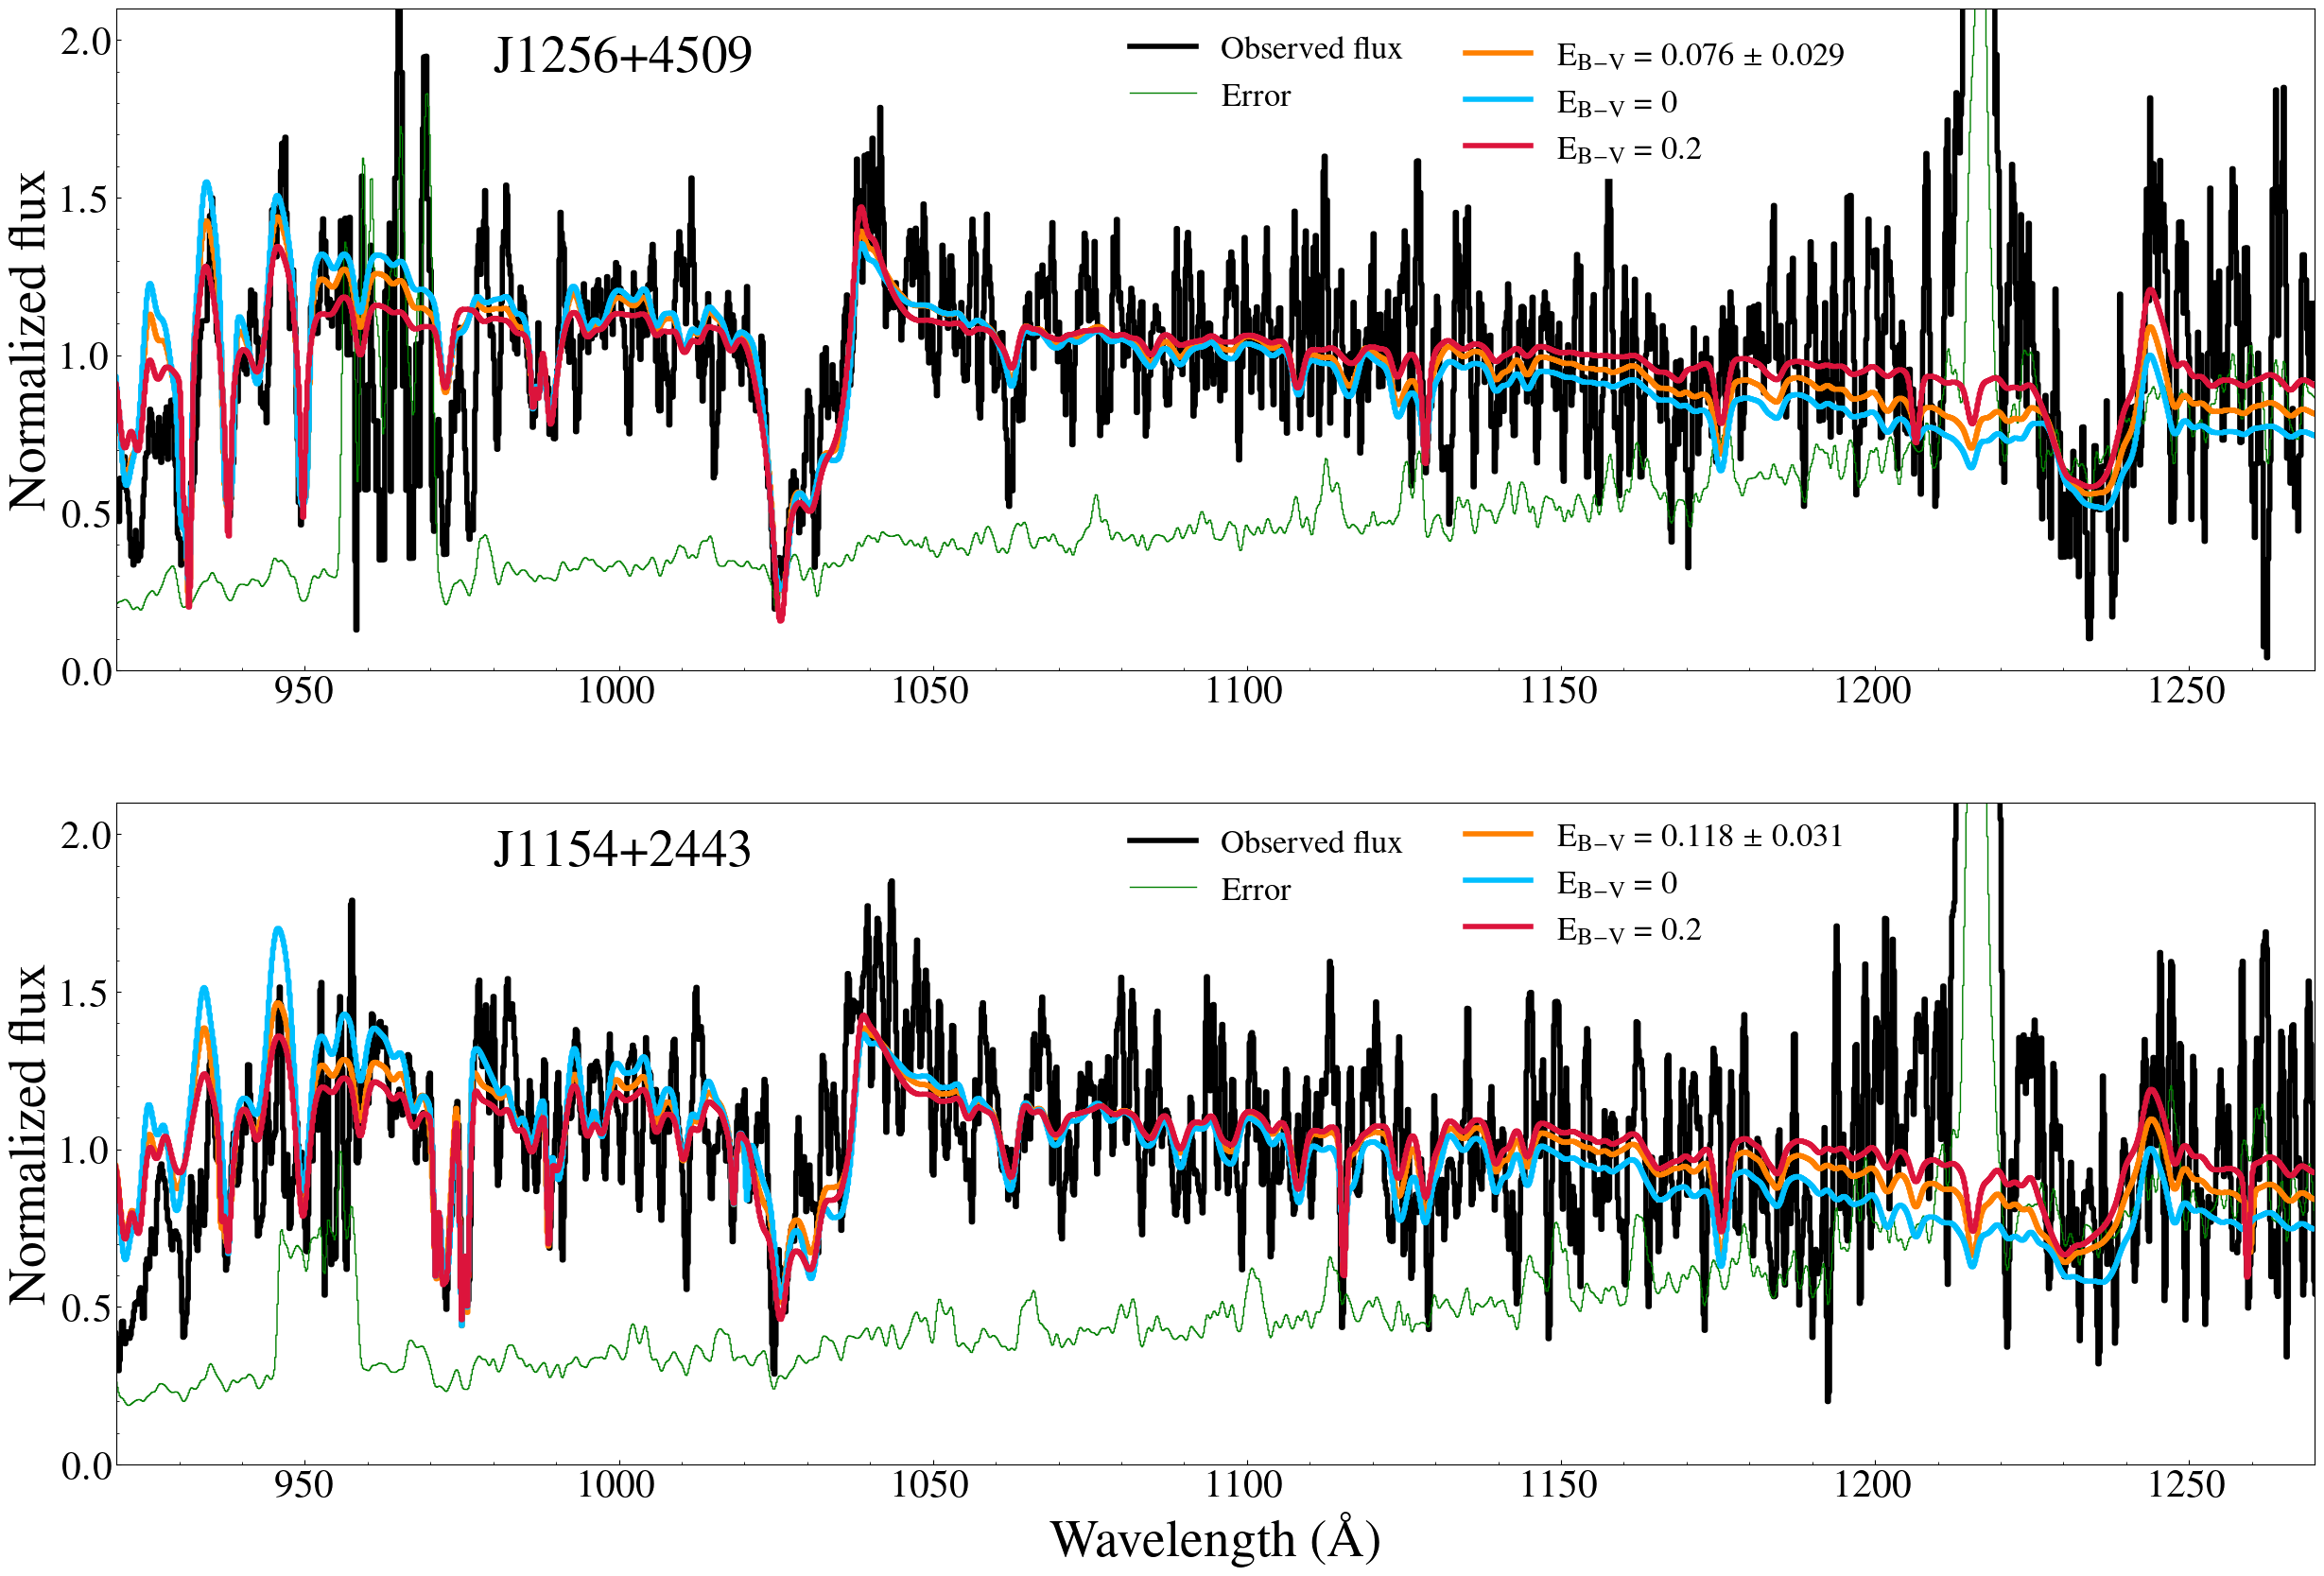

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.legend import Legend

df = pd.read_csv('Data/J12564509/FitFiles/J12564509_fit_all_free.csv')
df3 = pd.read_csv('Data/J12564509/FitFiles/J12564509_fit_all_ebv0.csv')
df4 = pd.read_csv('Data/J12564509/FitFiles/J12564509_fit_all_ebv02.csv')

hduin  = fits.open('Data/J12564509/Spectra/J12564509g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.3530)
mask = [data.flux[i] for i in range(len(x)) if (x[i]>1050 and x[i] <1060) ]
fig = plt.figure(figsize=(30,20))
ax = plt.subplot(2, 1, 1)
lines = []
lines += ax.plot(x,df['flux'], linewidth = 4.0, color='k',drawstyle='steps-mid')
lines += ax.plot(x,gconv(data.sigma_flux/np.median(mask),2), linewidth = 1.0, color='g',drawstyle='steps-mid')
ax.legend(lines[:2], labels = ['Observed flux', 'Error'],fontsize=25, frameon=False, \
          bbox_to_anchor=(0.6, 0.8, 0., .0), loc = 4 )
#plt.gca().add_artist(legend1)

lines += ax.plot(x,df['fit'], linewidth = 4.0,drawstyle='steps-mid', color=[1,0.5,0], label = 'FDF')
#plt.plot(x,df2['fit'], linewidth = 4.0,drawstyle='steps-mid', color=[0,0.749,1])
lines += ax.plot(x,df3['fit'], linewidth = 4.0,drawstyle='steps-mid',color=[0,0.749,1])
lines += ax.plot(x,df4['fit'], linewidth = 4.0,drawstyle='steps-mid', color="#DC143C")

leg = Legend(ax, lines[2:], [r'E$_{\rm B-V}$ = 0.076 $\pm$ 0.029', r'E$_{\rm B-V}$ = 0', r'E$_{\rm B-V}$ = 0.2'] ,\
             bbox_to_anchor=(0.8, 0.72, 0., .0),\
          loc = 4,fontsize=25, frameon=True, ncol=1 , framealpha=1)
ax.add_artist(leg)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.text(980,1.9,'J1256+4509', fontsize=40, family = "serif")
plt.ylim(0,2.1)
plt.xlim(920,1270)
plt.tick_params(axis = 'both', which = 'both', labelsize = 30)
plt.ylabel(r'Normalized flux', fontsize=40)



df = pd.read_csv('Data/J1154/FitFiles/J1154+2443_fit_all_free_smc.csv')
df3 = pd.read_csv('Data/J1154/FitFiles/J1154+2443_fit_all_fix_ebv0.csv')
df4 = pd.read_csv('Data/J1154/FitFiles/J1154+2443_fit_all_fix_ebv020.csv')
hduin  = fits.open('Data/J1154/Spectra/J1154+2443g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.369)
mask = [data.flux[i] for i in range(len(x)) if (x[i]>1050 and x[i] <1060) ]
ax = plt.subplot(2, 1, 2)
lines = []
lines += ax.plot(x,gconv(df['flux'],1), linewidth = 4.0, color='k',drawstyle='steps-mid')
lines += ax.plot(x,gconv(data.sigma_flux/np.median(mask),2), linewidth = 1.0, color='g',drawstyle='steps-mid')
ax.legend(lines[:2], labels = ['Observed flux', 'Error'],fontsize=25, frameon=False, \
          bbox_to_anchor=(0.6, 0.8, 0., .0), loc = 4 )

lines += ax.plot(x,df['fit'], linewidth = 4.0,drawstyle='steps-mid', color=[1,0.5,0], label = 'FDF')
#plt.plot(x,df2['fit'], linewidth = 4.0,drawstyle='steps-mid', color=[0,0.749,1])
lines += ax.plot(x,df3['fit'], linewidth = 4.0,drawstyle='steps-mid',color=[0,0.749,1])
lines += ax.plot(x,df4['fit'], linewidth = 4.0,drawstyle='steps-mid', color="#DC143C")

leg = Legend(ax, lines[2:], [r'E$_{\rm B-V}$ = 0.118 $\pm$ 0.031', r'E$_{\rm B-V}$ = 0', r'E$_{\rm B-V}$ = 0.2'] ,bbox_to_anchor=(0.8, 0.74, 0., .0),\
          loc = 4,fontsize=25, frameon=False, ncol=1,facecolor='white', framealpha=1 )

ax.add_artist(leg)
plt.text(980,1.9,'J1154+2443', fontsize=40, family = "serif")
#plt.gca().add_artist(legend1)
plt.tick_params(axis = 'both', which = 'both', labelsize = 30)
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=40)
plt.ylabel(r'Normalized flux', fontsize=40)

plt.ylim(0,2.1)
plt.xlim(920,1270)
# plt.savefig('fixebv_new.pdf',bbox_inches = 'tight',    pad_inches = 0)
plt.show()


# Plot HI lines

Filename: Data/J12564509/Spectra/J12564509g140lbin3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1                1 BinTableHDU    164   4272R x 21C   [1E, 1E, 1I, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


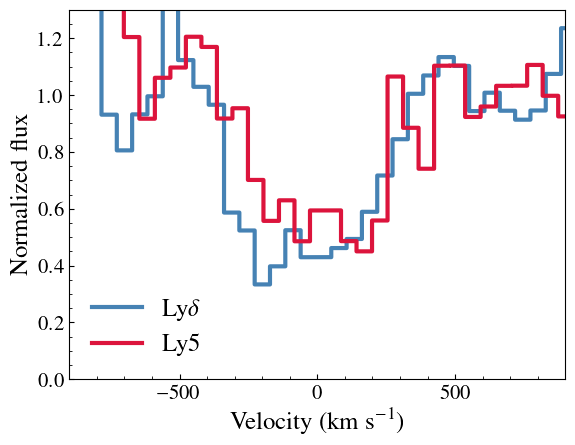

In [18]:
hduin  = fits.open('Data/J12564509/Spectra/J12564509g140lbin3.fits')
hdr = hduin[1].header
data = hduin[1].data
vmin = -1000
vmax = 500
vfcovmin =-100
vfcovmax =200
x = data.wave/(1+0.3530)
x = smooth(x,window_len=4,window='hanning')
flux = smooth(data.flux,window_len=4,window='hanning')
vlyd = (x/949.7431 -1) * 2.99e5
#fluxlyd = [flux[i] for i in range(len(vlyd)) if (vlyd > 500 & vlyd < 1000)]
fluxly5 = flux / 0.70e-16
fluxlyd = flux / 0.82e-16
vly5 = (x/937.8035 -1) * 2.99e5
vly6 = (x/930.751 -1) * 2.99e5

plt.plot(vlyd, fluxlyd,drawstyle='steps-mid',linewidth=3.0, linestyle='-', c = '#4682B4')
plt.plot(vly5, fluxly5,drawstyle='steps-mid',linewidth=3.0, linestyle='-', c = '#DC143C')
plt.xlim((-900,900))
plt.ylim((0,1.3))
plt.legend([r'Ly$\delta$', 'Ly5'],frameon=False, fontsize = 18)
plt.xlabel(r'Velocity (km s$^{-1}$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 

# plt.savefig('J1256hi.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_446965/1779268537.py:19: RuntimeWarning: invalid value encountered in power
  fluxlyd = flux**1.5


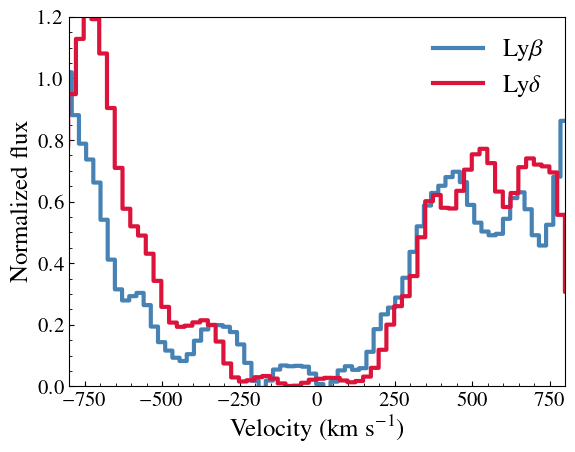

In [20]:
hduin  = fits.open('Data/GP10545238/Spectra/GP1054+5238.fits')
hdr = hduin[1].header
data = hduin[1].data[0]
vmin = -1000
vmax = 500
vfcovmin =-100
vfcovmax =200
x = data[0]#/(1+0.3530)
x = smooth(x,window_len=6,window='hanning')
flux = smooth(data[1],window_len=6,window='hanning')
#plt.plot(x,flux)
vlyb = (x/1025.762 -1) * 2.99e5
vlyg = (x/972.517 -1) * 2.99e5
vlyd = (x/949.7431 -1) * 2.99e5
#fluxlyd = [flux[i] for i in range(len(vlyd)) if (vlyd > 500 & vlyd < 1000)]
flux = flux/0.8
vly5 = (x/937.8035 -1) * 2.99e5
vly6 = (x/930.751 -1) * 2.99e5
fluxlyd = flux**1.5
fluxlyb = flux

plt.plot(vlyb, fluxlyb,drawstyle='steps-mid',linewidth=3.0, linestyle='-', c = '#4682B4')
plt.plot(vlyd, fluxlyd,drawstyle='steps-mid',linewidth=3.0, linestyle='-', c = '#DC143C')
plt.xlim((-800,800))
plt.ylim((0,1.2))
plt.legend([r'Ly$\beta$', r'Ly$\delta$'],frameon=False, fontsize = 18)
plt.xlabel(r'Velocity (km s$^{-1}$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 

# plt.savefig('GP1054hi.pdf', bbox_inches='tight')
plt.show()

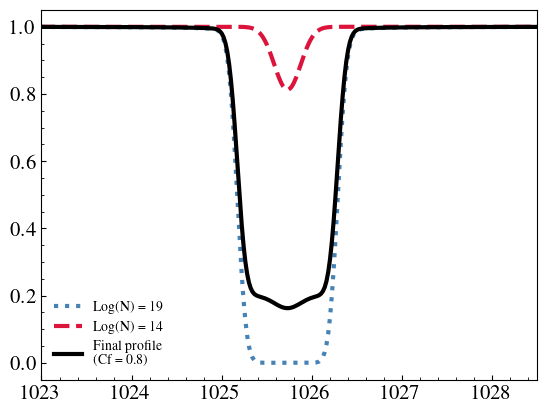

In [21]:
df = pd.read_csv('Data/syntheticly.csv',  header=None)
plt.plot(df[0], df[1], c = '#4682B4',linewidth=3.0, linestyle=':')
plt.plot(df[0], df[2], c = '#DC143C',linewidth=3.0, linestyle='--')
plt.plot(df[0], df[3],linewidth=3.0, linestyle='-', c='k')
plt.legend([u'Log(N) = 19',u'Log(N) = 14', u'Final profile\n(Cf = 0.8)'],frameon=False, fontsize = 10,loc = 3)
plt.xlim((1023,1028.5))
plt.savefig('synth.pdf')

# Plot Lya and Lyman

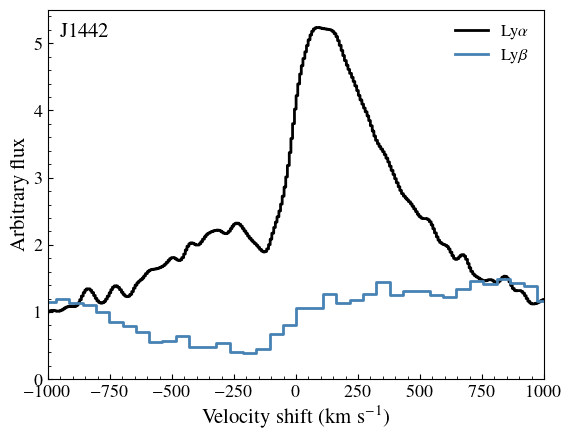

In [26]:
#GP0911+0931
from astropy.io import ascii
from scipy.signal import savgol_filter

dfa = pd.read_csv('Data/J1442/FitFiles/J1442-0209lya.csv',  header=None)
dfb = pd.read_csv('Data/J1442/FitFiles/J1442-0209lyb.csv',  header=None)

wave = dfb[0]
absorp = dfb[4]
vlya = dfa[0]
flya = dfa[1]
f = scipy.interpolate.interp1d(vlya, flya)
f2 = scipy.interpolate.interp1d(wave, absorp)

wavely = wave

vlyb = (wavely/1025.762 -1) * 2.99e5
vlyg = (wavely/972.517 -1) * 2.99e5
vlyd = (wavely/949.7431 -1) * 2.99e5
vly5 = (wavely/937.7431 -1) * 2.99e5

validlyb = (vlyb > -2500) & (vlyb < 2500)
validlyg = (vlyg > -1500) & (vlyg < 1500)
validlyd = (vlyd > -1500) & (vlyd < 1500)
validly5 = (vly5 > -1500) & (vly5 < 1500)

sigma_pix = np.sqrt(abs((vlyb[1]-vlyb[0])**2 - (vlya[0]-vlya[1])**2))  /(vlya[1]-vlya[0])
flya=gconv(f(vlya),np.sqrt(sigma_pix))
validlya = (vlya > -2500) & (vlya < 2500)


absorp[(absorp < 0)] = 0
flya[(flya<0)] = 0
flya = flya**0.4#np.log(flya)+1
flya[(flya<0)] = 0

fig, ax = plt.subplots()

plt.plot(vlya[validlya], flya[validlya], color='k',drawstyle='steps-mid',linewidth=2)
plt.plot(vlyb[validlyb], absorp[validlyb] , c = '#4682B4',drawstyle='steps-mid',  linewidth=2.0, linestyle='-')

plt.xlim((-1000,1000))
plt.ylim((-0.0,5.5))

plt.legend([r'Ly$\alpha$',r'Ly$\beta$'],frameon=False, fontsize = 12,loc = 0) #,r'Ly$\delta$'
plt.xlabel(r'Velocity shift (km s$^{-1}$)', fontsize = 15)
plt.ylabel('Arbitrary flux', fontsize = 15)
posx = -950
posy = 5.1
plt.text(posx, posy, 'J1442', fontsize = 15
ax.tick_params(axis='both', which='major', labelsize=13) 
# plt.savefig('PaperW/LYA/Figs/'+name+'ly.pdf', bbox_inches='tight')


/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


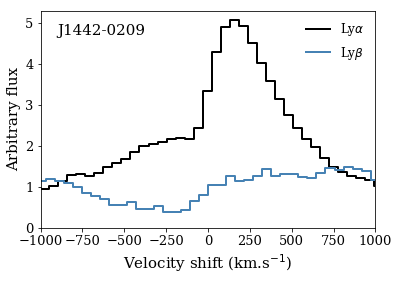

In [140]:
vlya = np.arange(0-2000, 2000,(vlyb[1]-vlyb[0]))
flya=f(vlya)
flya=gconv(f(vlya),1,1)

validlya = (vlya > -2000) & (vlya < 2000)

absorp[(absorp < 0)] = 0
flya[(flya<0)] = 0
flya =flya**0.4
flya[(flya<0)] = 0

fig, ax = plt.subplots()
#ax.axvspan(500, 1000, alpha=0.5, color='gray')
plt.plot(vlya[validlya], flya[validlya], color='k',drawstyle='steps-mid',linewidth=2)
plt.plot(vlyb[validlyb], absorp[validlyb] , c = '#4682B4',drawstyle='steps-mid',  linewidth=2.0, linestyle='-')
#plt.plot(vlyd[validlyd], absorp[validlyd],c = '#ffa500',drawstyle='steps-mid',  linewidth=3.0, linestyle='-')


plt.xlim((-1000,1000))
plt.ylim((0,5.3))
plt.legend([r'Ly$\alpha$',r'Ly$\beta$',r'Ly$\delta$'],frameon=False, fontsize = 12,loc = 1)
plt.xlabel(r'Velocity shift (km.s$^{-1}$)', fontsize = 15)
plt.ylabel('Arbitrary flux', fontsize = 15)
posx = -900
posy = 4.7
plt.text(posx, posy, name, fontsize = 15)
# plt.text(posx, posy-0.4, r'$f_{\rm esc}$(LyC) = 0.084', fontsize = 10)
# plt.text(posx, posy-0.8, r'$f_{\rm esc}$(Ly$\alpha$) = 0.54 +- 0.05', fontsize = 10)
# plt.text(posx, posy-1.2, 'Cf(HI) = 0.56 +- 0.04', fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=13) 
plt.savefig('PaperW/LYA/Figs/'+name+'lystep.pdf', bbox_inches='tight')


# Reading measurements

In [30]:
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("Measurements/Summary_paper.csv") 

# Preview the first 5 lines of the loaded data 
data.head()

,Label,case,sampl,types,zused,R,SN,logoh,Errlogoh,Models,...,Errfcovsicorr,fesctot,Errz,fesclyames.1,ratioatt,ratioobs,Attlycred,Attlyared,Attlycsmc,Attlyasmc
0,J0921+4509,1.0,0.0,1.0,0.2350,20.0,3.27,8.67,0.14,Z,...,0.016,0.017,0.0,0.031,0.547066,0.942529,NaN,NaN,NaN,NaN
1,J1503+3644,12.0,0.0,1.0,0.3557,200.0,3.30,7.95,0.06,Z02,...,0.012,0.021,0.0,0.038,0.554549,0.194757,NaN,NaN,NaN,NaN
2,J0925+1403,13.0,0.0,1.0,0.3013,200.0,3.40,7.91,0.03,Z02,...,0.023,0.053,0.0,0.081,0.640442,0.246775,NaN,NaN,NaN,NaN
3,J1152+3400,14.0,0.0,1.0,0.3419,200.0,2.80,8.00,0.07,Z02,...,0.020,0.068,0.0,0.101,0.676208,0.391361,NaN,NaN,NaN,NaN
4,J1333+6246,15.0,0.0,1.0,0.3181,200.0,2.37,7.76,0.11,Z005,...,0.041,0.033,0.0,0.049,0.663468,0.110887,NaN,NaN,NaN,NaN


# Spectra with zoom in

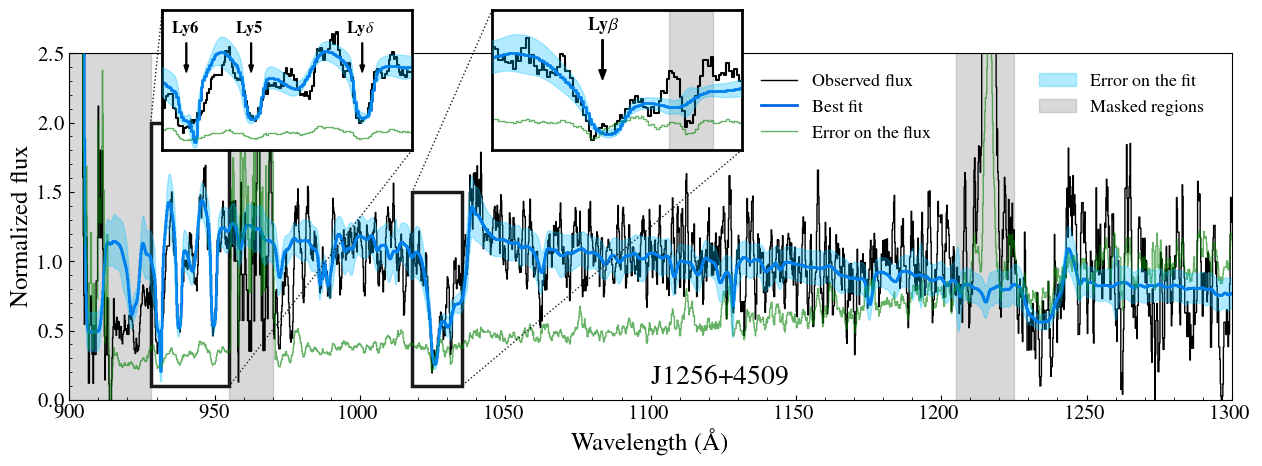

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

df1 = pd.read_csv('Data/J12564509/FitFiles/J12564509_fit_all_free.csv')

hduin  = fits.open('Data/J12564509/Spectra/J12564509g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.3530)
plt.figure(figsize=(15,4.5))

plt.plot(x,df1['flux'], linewidth = 1., color='k',drawstyle='steps-mid', label='Observed flux')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

ax = plt.gca()
totf = []
plt.xlim(900,1300)
plt.ylim(0,2)

for i in range(20):
    df = pd.read_csv('Data/J12564509/FitFiles/STDfits/J1256+4509fit_%d.csv'%i)
    totf.append(np.asarray(df))


toterr = np.sqrt(np.nanstd(np.asarray(totf), axis=0).reshape(-1)**2 + ((np.nanmean(np.asarray(totf), axis=0)).reshape(-1)-df1['fit'][:-1])**2)
newfit1= np.asarray(df1['fit'])[:-1] + toterr
newfit2= np.asarray(df1['fit'])[:-1] - toterr
newfit2[newfit2<0.13] =0.13

plt.fill_between(x[:-1],newfit1,newfit2, color=[0,0.75,1], zorder=3, alpha = 0.3, label ='Error on the fit' )
plt.xlim(900,1300)
plt.ylim(0,2.5)
ax.axvspan(900, 928, alpha=0.3, color='gray', label ='Masked regions')
ax.axvspan(955, 970, alpha=0.3, color='gray')
ax.axvspan(1205, 1225, alpha=0.3, color='gray')
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 
valid = (x[:-1] < 1050) & (x[:-1] > 1000)

leg = plt.legend(bbox_to_anchor=(0.99, 0.7, 0., .0),columnspacing = 6,\
          loc = 4,fontsize=13, frameon=False, facecolor='white', framealpha=1 , ncol=2)
plt.text(1100,0.1,r'J1256+4509', color='k', fontsize = 20)


axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.4, 1),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=2, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
    #axins.spines[axis].set_color('r')
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')

plt.plot(x,df1['flux'], linewidth = 1.5, color='k',drawstyle='steps-mid', label='Observed flux')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')
plt.fill_between(x[:-1],newfit1,newfit2, color=[0,0.75,1], zorder=3, alpha = 0.3 )

axins.set_xlim(1018, 1035)
axins.set_ylim(0.1, 1.5)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.text(1024.5,1.3,r'$\rm \mathbf{Ly\beta}$', color='k', fontsize = 13)
plt.arrow(1025.5, 1.2, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
axins.axvspan(1030, 1033, alpha=0.3, color='gray')

axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.18, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=2, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
    #axins.spines[axis].set_color('r')
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')
plt.plot(x,df1['flux'], linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
plt.fill_between(x[:-1],newfit1,newfit2, color=[0,0.75,1], zorder=3, alpha = 0.3 )
axins.set_xlim(928, 955)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
plt.text(936,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)
plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(930.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)


In [ ]:
import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
# import plottools

%matplotlib inline
df1 = pd.read_csv('montefit/J0901+2119_fit_all_free.csv')
#print df1.head
hduin  = fits.open('Workspace/J0901+2119/J0901+2119g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.2993)
plt.figure(figsize=(15,4.5))

plt.plot(x,gconv(df1['flux'],1.1,1), linewidth = 1., color='k',drawstyle='steps-mid', label='Observed flux', zorder = 0)
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

ax = plt.gca()
totf = []
plt.xlim(900,1300)
plt.ylim(0,2)


#plt.plot(x[:-1], newfit1 , linewidth = 1.0, color='b',drawstyle='steps-mid', ls ='--')
plt.xlim(900,1300)
plt.ylim(0,3.)
ax.axvspan(900, 955, alpha=0.3, color='gray', label ='Masked regions')
ax.axvspan(1255, 1300, alpha=0.3, color='gray')
ax.axvspan(1205, 1225, alpha=0.3, color='gray')
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 
valid = (x[:-1] < 1050) & (x[:-1] > 1000)

leg = plt.legend(bbox_to_anchor=(0.76, 0.62, 0., .0),columnspacing = 6,\
          loc = 4,fontsize=13, frameon=True, facecolor='white', framealpha=1)
plt.text(1100,0.1,r'J0901+2119', color='k', fontsize = 18)
leg.get_frame().set_linewidth(0)




# ax_zoom = plottools.zoom_axes(fig,ax,[1022,1032],[1,0],[1050,1100],[0,1],box_color='k', \
#                               box_alpha=1, connect=True, connect_color='k', connect_alpha=1,)
# ax_zoom.plot(x,df1['flux'], color=[0,0.749,1])
axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.4, 1),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=2, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')
plt.plot(x,gconv(df1['flux'],1.1,1), linewidth = 1.5, color='k',drawstyle='steps-mid', label='Observed flux')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

axins.set_xlim(1018, 1035)
axins.set_ylim(0.1, 1.5)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.text(1025,1.3,r'$\rm \mathbf{Ly\beta}$', color='k', fontsize = 13)
plt.arrow(1026, 1.2, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
axins.axvspan(1030, 1037, alpha=0.3, color='gray')

axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.18, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')

plt.plot(x,gconv(df1['flux'],1.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(965, 980)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
# plt.text(936,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
# plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)
plt.text(971.5,1.7,r'$\rm \mathbf{Ly\gamma}$', color='k', fontsize = 12)

plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(930.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(972.5, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,      # ticks along the bottom edge are off
#     labelbottom=False) # labels along the bottom edge are off
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
#print (np.nanstd(np.asarray(totf), axis=0)[valid]).reshape(-1)
#print np.asarray(df1['fit'])[:-1][valid]
plt.savefig('J0901+2119_fit.pdf', bbox_inches='tight')


/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:147: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


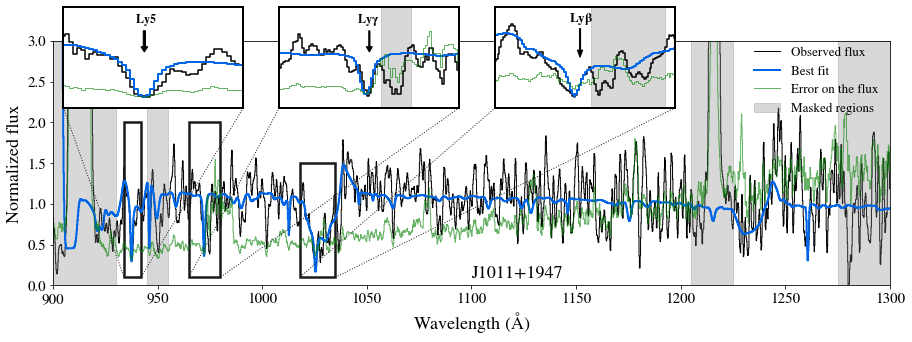

In [10]:
import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import plottools

%matplotlib inline
df1 = pd.read_csv('montefit/J1011+1947_fit_all_free.csv')
#print df1.head
hduin  = fits.open('Workspace/J1011+1947/J1011+1947g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.33225)
plt.figure(figsize=(15,4.5))

plt.plot(x,gconv(df1['flux'],1.,1), linewidth = 1., color='k',drawstyle='steps-mid', label='Observed flux', zorder = 0)
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

ax = plt.gca()
totf = []
plt.xlim(900,1300)
plt.ylim(0,2)


#plt.plot(x[:-1], newfit1 , linewidth = 1.0, color='b',drawstyle='steps-mid', ls ='--')
plt.xlim(900,1300)
plt.ylim(0,3.)
ax.axvspan(900, 930, alpha=0.3, color='gray',)
ax.axvspan(945, 955, alpha=0.3, color='gray', label ='Masked regions')

ax.axvspan(1275, 1300, alpha=0.3, color='gray')
ax.axvspan(1205, 1225, alpha=0.3, color='gray')
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 
valid = (x[:-1] < 1050) & (x[:-1] > 1000)

leg = plt.legend(bbox_to_anchor=(1., 0.65, 0., .0),columnspacing = 6,\
          loc = 4,fontsize=13, frameon=False, facecolor='white', framealpha=1)
plt.text(1100,0.1,r'J1011+1947', color='k', fontsize = 18)
leg.get_frame().set_linewidth(0)




# ax_zoom = plottools.zoom_axes(fig,ax,[1022,1032],[1,0],[1050,1100],[0,1],box_color='k', \
#                               box_alpha=1, connect=True, connect_color='k', connect_alpha=1,)
# ax_zoom.plot(x,df1['flux'], color=[0,0.749,1])
axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.53, 1),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')

plt.plot(x,gconv(df1['flux'],1.,1), linewidth = 1.5, color='k',drawstyle='steps-mid', label='Observed flux')
plt.plot(x,df1['fit']+0.1, linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

axins.set_xlim(1018, 1035)
axins.set_ylim(0.1, 1.5)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.text(1025,1.3,r'$\rm \mathbf{Ly\beta}$', color='k', fontsize = 13)
plt.arrow(1026, 1.2, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
axins.axvspan(1027, 1034, alpha=0.3, color='gray')

axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.33, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')

plt.plot(x,gconv(df1['flux'],0.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(965, 980)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
# plt.text(936,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
# plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)
plt.text(971.5,1.7,r'$\rm \mathbf{Ly\gamma}$', color='k', fontsize = 12)
axins.axvspan(973.5, 976, alpha=0.3, color='gray')

plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = .011)
plt.arrow(930.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(972.5, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)


axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.13, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')

plt.plot(x,gconv(df1['flux'],0.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(934, 942)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
#plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
plt.text(937.2,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
#plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)

plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.3, head_length=0.1, fc='k', ec='k', width =0.1)
plt.arrow(930.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(972.5, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,      # ticks along the bottom edge are off
#     labelbottom=False) # labels along the bottom edge are off
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
#print (np.nanstd(np.asarray(totf), axis=0)[valid]).reshape(-1)
##print np.asarray(df1['fit'])[:-1][valid]
plt.savefig('J1011+1947_fit.pdf', bbox_inches='tight')


/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:147: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


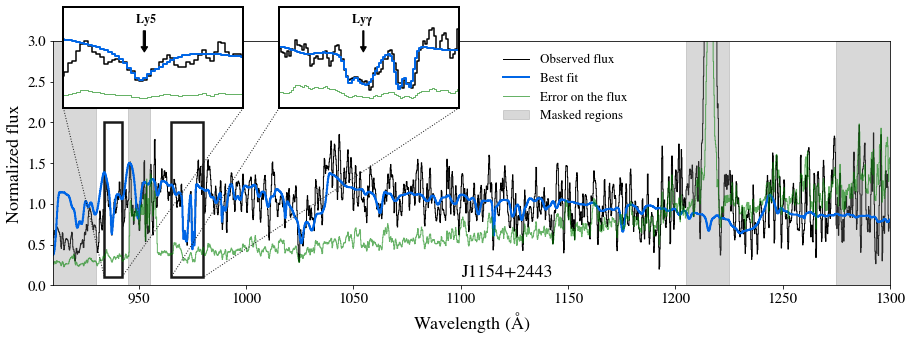

In [14]:
import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import plottools

%matplotlib inline
df1 = pd.read_csv('montefit/J1154+2443_fit_all_free.csv')
#print df1.head
hduin  = fits.open('Workspace/J1154/J1154+2443g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.369)
plt.figure(figsize=(15,4.5))

plt.plot(x,gconv(df1['flux'],1.,1), linewidth = 1., color='k',drawstyle='steps-mid', label='Observed flux', zorder = 0)
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,gconv(data.sigma_flux,1,1)/np.nanmedian(data.flux), linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

ax = plt.gca()
totf = []


#plt.plot(x[:-1], newfit1 , linewidth = 1.0, color='b',drawstyle='steps-mid', ls ='--')
plt.xlim(910,1300)
plt.ylim(0,3.)
ax.axvspan(900, 930, alpha=0.3, color='gray',)
ax.axvspan(945, 955, alpha=0.3, color='gray', label ='Masked regions')

ax.axvspan(1275, 1300, alpha=0.3, color='gray')
ax.axvspan(1205, 1225, alpha=0.3, color='gray')
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 
valid = (x[:-1] < 1050) & (x[:-1] > 1000)

leg = plt.legend(bbox_to_anchor=(0.7, 0.62, 0., .0),columnspacing = 6,\
          loc = 4,fontsize=13, frameon=True, facecolor='white', framealpha=1)
plt.text(1100,0.1,r'J1154+2443', color='k', fontsize = 18)
leg.get_frame().set_linewidth(0)




# ax_zoom = plottools.zoom_axes(fig,ax,[1022,1032],[1,0],[1050,1100],[0,1],box_color='k', \
#                               box_alpha=1, connect=True, connect_color='k', connect_alpha=1,)
# ax_zoom.plot(x,df1['flux'], color=[0,0.749,1])
# axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.53, 1),bbox_transform=ax.figure.transFigure)
# mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
# plt.plot(x,gconv(df1['flux'],1.,1), linewidth = 1.5, color='k',drawstyle='steps-mid', label='Observed flux')
# plt.plot(x,df1['fit']+0.1, linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
# plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

# axins.set_xlim(1018, 1035)
# axins.set_ylim(0.1, 1.5)
# plt.tick_params(axis=u'both', which=u'both',length=0)
# plt.xticks(visible=False)
# plt.yticks(visible=False)
# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,      # ticks along the bottom edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.text(1025,1.3,r'$\rm \mathbf{Ly\beta}$', color='k', fontsize = 13)
# plt.arrow(1026, 1.2, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
# axins.axvspan(1027, 1034, alpha=0.3, color='gray')

axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.33, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')
plt.plot(x,gconv(df1['flux'],0.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,gconv(data.sigma_flux,1,1)/np.nanmedian(data.flux), linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(965, 980)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
# plt.text(936,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
# plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)
plt.text(971.,1.7,r'$\rm \mathbf{Ly\gamma}$', color='k', fontsize = 12)
#axins.axvspan(973.5, 976, alpha=0.3, color='gray')

plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k')
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k')
plt.arrow(930.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(972., 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)


axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.13, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')



plt.plot(x,gconv(df1['flux'],0.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,gconv(data.sigma_flux,1,1)/np.nanmedian(data.flux), linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(934, 942)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
#plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
plt.text(937.2,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
#plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)

plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k')
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.3, head_length=0.1, fc='k', ec='k', width= 0.1)
plt.arrow(930.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(972.5, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,      # ticks along the bottom edge are off
#     labelbottom=False) # labels along the bottom edge are off
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
#print (np.nanstd(np.asarray(totf), axis=0)[valid]).reshape(-1)
##print np.asarray(df1['fit'])[:-1][valid]
plt.savefig('J1154+2443_fit.pdf', bbox_inches='tight')


/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:147: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


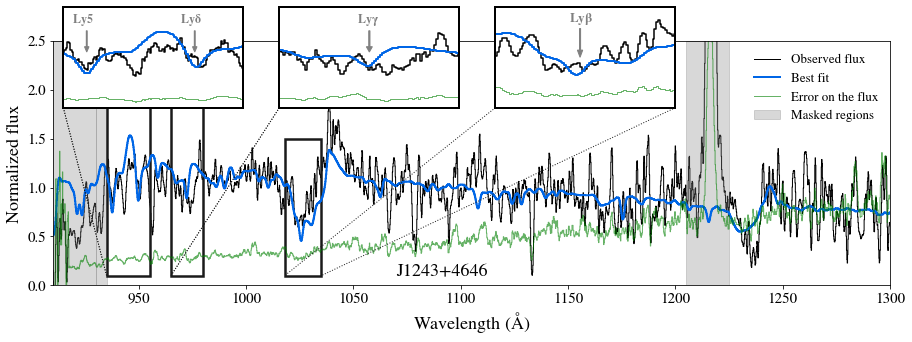

In [27]:
import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import plottools

%matplotlib inline
df1 = pd.read_csv('montefit/J1243+4646_fit_all_free.csv')
#print df1.head
hduin  = fits.open('Workspace/J1243+4646/J1243+4646g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.4317)
plt.figure(figsize=(15,4.5))

plt.plot(x,gconv(df1['flux'],1.,1), linewidth = 1., color='k',drawstyle='steps-mid', label='Observed flux', zorder = 0)
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

ax = plt.gca()
totf = []


#plt.plot(x[:-1], newfit1 , linewidth = 1.0, color='b',drawstyle='steps-mid', ls ='--')
plt.xlim(910,1300)
plt.ylim(0,2.5)
ax.axvspan(900, 930, alpha=0.3, color='gray',)
ax.axvspan(930, 935, alpha=0.3, color='gray', label ='Masked regions')

#ax.axvspan(1275, 1300, alpha=0.3, color='gray')
ax.axvspan(1205, 1225, alpha=0.3, color='gray')
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 
valid = (x[:-1] < 1050) & (x[:-1] > 1000)

leg = plt.legend(bbox_to_anchor=(1., 0.62, 0., .0),columnspacing = 6,\
          loc = 4,fontsize=13, frameon=True, facecolor='white', framealpha=1)
plt.text(1070,0.1,r'J1243+4646', color='k', fontsize = 18)
leg.get_frame().set_linewidth(0)

axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.53, 1),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')

plt.plot(x,gconv(df1['flux'],1.,1), linewidth = 1.5, color='k',drawstyle='steps-mid', label='Observed flux')
plt.plot(x,df1['fit']+0.1, linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

axins.set_xlim(1018, 1035)
axins.set_ylim(0.1, 1.5)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.text(1025,1.3,r'$\rm \mathbf{Ly\beta}$', color='gray', fontsize = 13)
plt.arrow(1026, 1.2, 0, -0.3, head_width=0.5, head_length=0.1, fc='gray', ec='gray', width = 0.1)
#axins.axvspan(1027, 1034, alpha=0.3, color='gray')

axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.33, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=3,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')

plt.plot(x,gconv(df1['flux'],0.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(965, 980)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
# plt.text(936,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
# plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)
plt.text(971.5,1.7,r'$\rm \mathbf{Ly\gamma}$', color='gray', fontsize = 12)
#axins.axvspan(973.5, 976, alpha=0.3, color='gray')


plt.arrow(972.5, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='gray', ec='gray', width = 0.1)


axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.13, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=3,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')
plt.plot(x,df1['flux'], linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
#plt.fill_between(x[:-1],newfit1,newfit2, color=[0,0.75,1], zorder=3, alpha = 0.3 )
axins.set_xlim(935, 955)
axins.set_ylim(0.1, 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.text(936,1.7,r'$\rm \mathbf{Ly5}$', color='gray', fontsize = 12)
plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='gray', fontsize = 12)
plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='gray', ec='gray', width = 0.1)
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='gray', ec='gray', width = 0.1)
plt.savefig('J1243+4646_fit.pdf', bbox_inches='tight')


/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:147: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


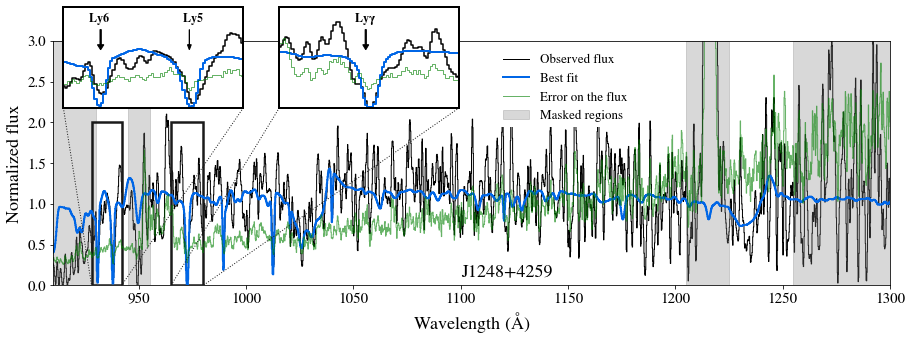

In [16]:
import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import plottools

%matplotlib inline
df1 = pd.read_csv('montefit/J1248+4259_fit_all_free.csv')
#print df1.head
hduin  = fits.open('Workspace/J1248+4259/J1248+4259g140lbin3.fits')
data = hduin[1].data
x = data.wave/(1+0.3629)
plt.figure(figsize=(15,4.5))

plt.plot(x,gconv(df1['flux'],1.5,1), linewidth = 1., color='k',drawstyle='steps-mid', label='Observed flux', zorder = 0)
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
plt.plot(x,gconv(data.sigma_flux,1,1)/np.nanmedian(data.flux)/1.9, linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

ax = plt.gca()
totf = []


#plt.plot(x[:-1], newfit1 , linewidth = 1.0, color='b',drawstyle='steps-mid', ls ='--')
plt.xlim(910,1300)
plt.ylim(0,3.)
ax.axvspan(900, 930, alpha=0.3, color='gray',)
ax.axvspan(945, 955, alpha=0.3, color='gray', label ='Masked regions')

ax.axvspan(1255, 1300, alpha=0.3, color='gray')
ax.axvspan(1205, 1225, alpha=0.3, color='gray')
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize = 18)
plt.ylabel('Normalized flux', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=15) 
valid = (x[:-1] < 1050) & (x[:-1] > 1000)

leg = plt.legend(bbox_to_anchor=(0.7, 0.62, 0., .0),columnspacing = 6,\
          loc = 4,fontsize=13, frameon=True, facecolor='white', framealpha=1)
plt.text(1100,0.1,r'J1248+4259', color='k', fontsize = 18)
leg.get_frame().set_linewidth(0)




# ax_zoom = plottools.zoom_axes(fig,ax,[1022,1032],[1,0],[1050,1100],[0,1],box_color='k', \
#                               box_alpha=1, connect=True, connect_color='k', connect_alpha=1,)
# ax_zoom.plot(x,df1['flux'], color=[0,0.749,1])
# axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.53, 1),bbox_transform=ax.figure.transFigure)
# mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
# plt.plot(x,gconv(df1['flux'],1.,1), linewidth = 1.5, color='k',drawstyle='steps-mid', label='Observed flux')
# plt.plot(x,df1['fit']+0.1, linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid', label='Best fit')
# plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6, label = 'Error on the flux')

# axins.set_xlim(1018, 1035)
# axins.set_ylim(0.1, 1.5)
# plt.tick_params(axis=u'both', which=u'both',length=0)
# plt.xticks(visible=False)
# plt.yticks(visible=False)
# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,      # ticks along the bottom edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.text(1025,1.3,r'$\rm \mathbf{Ly\beta}$', color='k', fontsize = 13)
# plt.arrow(1026, 1.2, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
# axins.axvspan(1027, 1034, alpha=0.3, color='gray')

axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.33, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')
plt.plot(x,gconv(df1['flux'],1.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(965, 980)
axins.set_ylim(0., 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.text(929,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
# plt.text(936,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
# plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)
plt.text(971.2,1.7,r'$\rm \mathbf{Ly\gamma}$', color='k', fontsize = 12)
#axins.axvspan(973.5, 976, alpha=0.3, color='gray')

plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k')
plt.arrow(937.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k')
plt.arrow(930.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
plt.arrow(972.2, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)


axins =  inset_axes(ax, 2.5,1.4 , loc=2,bbox_to_anchor=(0.13, 1.),bbox_transform=ax.figure.transFigure)
box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=4,  ec="0.1")
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
box.set_linewidth(2.5)
c1.set_linestyle(':')
c2.set_linestyle(':')


plt.plot(x,gconv(df1['flux'],1.5,1), linewidth = 1.5, color='k',drawstyle='steps-mid')
plt.plot(x,df1['fit'], linewidth = 2.0, color=[0,0.4,0.9],drawstyle='steps-mid')
plt.plot(x,df1['err'], linewidth = 1.0, color='g',drawstyle='steps-mid', alpha = 0.6)
axins.set_xlim(928, 942)
axins.set_ylim(0., 2.)

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.text(929.9,1.7,r'$\rm \mathbf{Ly6}$', color='k', fontsize = 12)
plt.text(937.2,1.7,r'$\rm \mathbf{Ly5}$', color='k', fontsize = 12)
#plt.text(948,1.7,r'$\rm \mathbf{Ly\delta}$', color='k', fontsize = 12)

plt.arrow(949.6, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k')
plt.arrow(937.8, 1.55, 0, -0.3, head_width=0.3, head_length=0.1, fc='k', ec='k')
plt.arrow(930.9, 1.55, 0, -0.3, head_width=0.5, head_length=0.1, fc='k', ec='k', width = 0.1)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,      # ticks along the bottom edge are off
#     labelbottom=False) # labels along the bottom edge are off
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
#print (np.nanstd(np.asarray(totf), axis=0)[valid]).reshape(-1)
##print np.asarray(df1['fit'])[:-1][valid]
plt.savefig('J1248+4259_fit.pdf', bbox_inches='tight')


# Plot Lya

/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:147: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


1218.71943972
1219.73588629


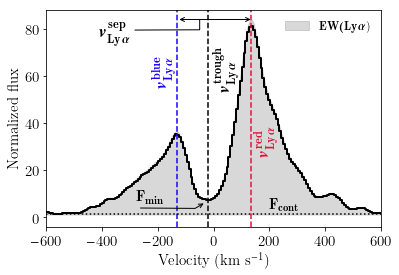

In [6]:

hduin  = fits.open('Workspace/J1011+1947/J1011+1947g140lbin3.fits')
hdr = hduin[1].header
data = hduin[1].data


wavelya = data.wave/1.3322
flya = gconv(data.flux,np.sqrt((21/2.3548)**2-(20/2.3548)**2)/2.3548,1)


dfa = pd.read_csv('Flux/J1011+1947lya.csv',  header=None)

vlya = dfa[0]
#print vlya
flya = gconv(dfa[1],np.sqrt((25/2.3548)**2-(20/2.3548)**2)/2.3548,1)
medint = (vlya > 750) & (vlya < 1000)
print (750/2.99e5 +1) *1215.6701 
print (1000/2.99e5 +1) *1215.6701 

med = np.median(flya[medint])


validlya = (vlya > -1500) & (vlya < 1500)
plt.plot(vlya[validlya], flya[validlya]/med, color='k',drawstyle='steps-mid',linewidth=2)
plt.axvline(x=-20, color='k', linestyle='--', alpha=1)
plt.axvline(x=-130, color=[0.1,0,1], linestyle='--')
plt.axvline(x=135, color='#DC143C', linestyle='--')
plt.text(0,63,r'\boldmath $v^{\rm trough}_{\rm Ly\alpha}$',rotation=90, color='k', fontsize = 17)
plt.text(-215,60,r'\boldmath $v^{\rm blue}_{\rm Ly\alpha}$',rotation=90, color=[0.1,0,1], fontsize = 17)
plt.text(150,30,r'\boldmath $v^{\rm red}_{\rm Ly\alpha}$',rotation=90, color='#DC143C', fontsize = 17)

#plt.axvline(x=10, color='k', linestyle='--')
plt.axhline(1.5, color='k', linestyle=':')
plt.text(200,3,r'\boldmath${\rm F_{\rm cont}}$', color='k', fontsize = 15)

plt.text(-280,6,r'\boldmath${\rm F_{\rm min}}$', color='k', fontsize = 15)

#plt.hlines(1,xmin=0, xmax=50,  color='g', linestyle='-')
plt.annotate(s='', xy=(-130,84), xytext=(140,84), arrowprops=dict(arrowstyle='<->'))
#plt.hlines(y=84, xmin = -200, xmax = -110, color='k', linestyle='-')
plt.annotate("",
            xy=(-50, 86), xycoords='data',
            xytext=(-300, 79.5), textcoords='data',
            arrowprops=dict(arrowstyle="-", color="k",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc,angleA=40,angleB=90,armA=0,armB=-15,rad=0",
                            ),
                            )
plt.text(-410,74,r'\boldmath $v^{\rm sep}_{\rm Ly\alpha}$',rotation=0, color='k', fontsize = 17)

plt.annotate("",
            xy=(-20, 7), xycoords='data',
            xytext=(-280, 4), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc,angleA=40,angleB=30,armA=0,armB=-15,rad=0",
                            ),
                            )

plt.fill_between(vlya, 1, flya, color= 'gray', alpha = 0.3, label = r'\boldmath ${\rm EW(Ly\alpha}$)')

plt.xlim((-600,600))
#plt.ylim((0,10))
plt.legend(frameon=False, fontsize = 12,loc = 1)
plt.xlabel(r'Velocity (km s$^{-1}$)', fontsize = 15)
plt.ylabel('Normalized flux', fontsize = 15)
#plt.text(-1000, 0.2, "J1442-0209", fontsize = 10)
#plt.text(350, 0.3, r'$v^{\rm sep}_{\rm Ly\alpha}$ = 320 km.s$^{-1}$', fontsize = 10)
#plt.text(350, 0.1, r'$v^{\rm width}_{\rm H I}$ = 371 km.s$^{-1}$', fontsize = 10)
plt.tick_params(axis = 'both', which = 'both', labelsize = 15)

plt.savefig('Lya_example.pdf', bbox_inches='tight')
#vlya = (s.wave/1215.6701 -1) * 2.99e5 r'Ly$\alpha$ trough', 
plt.show()
